## ⼩批量随机梯度下降
到⽬前为⽌，我们在基于梯度的学习⽅法中遇到了两个极端情况：11.3节中使⽤完整数据集来计算梯度并更
新参数，11.4节中⼀次处理⼀个训练样本来取得进展。⼆者各有利弊：每当数据⾮常相似时，梯度下降并不
是⾮常“数据⾼效”。⽽由于CPU和GPU⽆法充分利⽤向量化，随机梯度下降并不特别“计算⾼效”。这暗⽰
了两者之间可能有折中⽅案，这便涉及到⼩批量随机梯度下降（minibatch gradient descent）。

## 向量化和缓存
使⽤⼩批量的决策的核⼼是计算效率。当考虑与多个GPU和多台服务器并⾏处理时，这⼀点最容易被理解。
在这种情况下，我们需要向每个GPU发送⾄少⼀张图像。有了每台服务器8个GPU和16台服务器，我们就能得
到⼤⼩为128的⼩批量。

当涉及到单个GPU甚⾄CPU时，事情会更微妙⼀些：这些设备有多种类型的内存、通常情况下多种类型的计
算单元以及在它们之间不同的带宽限制。例如，⼀个CPU有少量寄存器（register），L1和L2缓存，以及L3缓
存（在不同的处理器内核之间共享）。随着缓存的⼤⼩的增加，它们的延迟也在增加，同时带宽在减少。可以
说，处理器能够执⾏的操作远⽐主内存接⼝所能提供的多得多。

⾸先，具有16个内核和AVX-512向量化的2GHz CPU每秒可处理⾼达2 · 109
· 16 · 32 = 1012个字节。同时，GPU的性能很容易超过该数字100倍。⽽另⼀⽅⾯，中端服务器处理器的带宽可能不超过100Gb/s，即不到处理器满
负荷所需的⼗分之⼀。更糟糕的是，并⾮所有的内存⼊⼝都是相等的：内存接⼝通常为64位或更宽（例如，在
最多384位的GPU上）。因此读取单个字节会导致由于更宽的存取⽽产⽣的代价。

其次，第⼀次存取的额外开销很⼤，⽽按序存取（sequential access）或突发读取（burst read）相对开销较
⼩。

减轻这些限制的⽅法是使⽤⾜够快的CPU缓存层次结构来为处理器提供数据。这是深度学习中批量处理背后
的推动⼒。举⼀个简单的例⼦：矩阵-矩阵乘法。⽐如A = BC，我们有很多⽅法来计算A。例如，我们可以尝
试以下⽅法：
* 我们可以计算Aij = Bi,:C⊤:,j，也就是说，我们可以通过点积进⾏逐元素计算。
* 我们可以计算A:,j = BC⊤:,j，也就是说，我们可以⼀次计算⼀列。同样，我们可以⼀次计算A⼀⾏Ai,:。
* 我们可以简单地计算A = BC。
* 我们可以将B和C分成较⼩的区块矩阵，然后⼀次计算A的⼀个区块。

如果我们使⽤第⼀个选择，每次我们计算⼀个元素Aij时，都需要将⼀⾏和⼀列向量复制到CPU中。更糟糕的
是，由于矩阵元素是按顺序对⻬的，因此当从内存中读取它们时，我们需要访问两个向量中许多不相交的位
置。第⼆种选择相对更有利：我们能够在遍历B的同时，将列向量C:,j保留在CPU缓存中。它将内存带宽需求
减半，相应地提⾼了访问速度。第三种选择表⾯上是最可取的，然⽽⼤多数矩阵可能不能完全放⼊缓存中。
第四种选择提供了⼀个实践上很有⽤的⽅案：我们可以将矩阵的区块移到缓存中然后在本地将它们相乘。让
我们来看看这些操作在实践中的效率如何。

除了计算效率之外，Python和深度学习框架本⾝带来的额外开销也是相当⼤的。回想⼀下，每次我们执⾏代
码时，Python解释器都会向深度学习框架发送⼀个命令，要求将其插⼊到计算图中并在调度过程中处理它。
这样的额外开销可能是⾮常不利的。总⽽⾔之，我们最好⽤向量化（和矩阵）。


In [6]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

按元素分配只需遍历分别为B和C的所有⾏和列，即可将该值分配给A。


In [7]:
# 逐元素计算A=BC
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()


0.9828927516937256

更快的策略是执⾏按列分配。

In [8]:
# 逐列计算A=BC
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()


0.012010812759399414

最有效的⽅法是在⼀个区块中执⾏整个操作。让我们看看它们各⾃的操作速度是多少。


In [9]:
# ⼀次性计算A=BC
timer.start()
A = torch.mm(B, C)
timer.stop()

# 乘法和加法作为单独的操作（在实践中融合）
gigaflops = [2/i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 2.035, column 166.517, full 285.453


### 小批量
之前我们会理所当然地读取数据的⼩批量，⽽不是观测单个数据来更新参数，现在简要解释⼀下原因。处理
单个观测值需要我们执⾏许多单⼀矩阵-⽮量（甚⾄⽮量-⽮量）乘法，这耗费相当⼤，⽽且对应深度学习框
架也要巨⼤的开销。这既适⽤于计算梯度以更新参数时，也适⽤于⽤神经⽹络预测。也就是说，每当我们执
⾏w ← w − ηtgt时，消耗巨⼤。其中

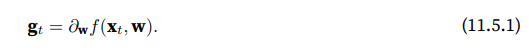

我们可以通过将其应⽤于⼀个⼩批量观测值来提⾼此操作的计算效率。也就是说，我们将梯度gt替换为⼀个
⼩批量⽽不是单个观测值

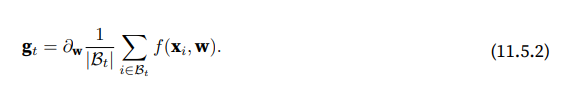

让我们看看这对gt的统计属性有什么影响：由于xt和⼩批量Bt的所有元素都是从训练集中随机抽出的，因此
梯度的期望保持不变。另⼀⽅⾯，⽅差显著降低。由于⼩批量梯度由正在被平均计算的b := |Bt|个独⽴梯度
组成，其标准差降低了b^(− 1/2) 。这本⾝就是⼀件好事，因为这意味着更新与完整的梯度更接近了。
直观来说，这表明选择⼤型的⼩批量Bt将是普遍可⾏的。然⽽，经过⼀段时间后，与计算代价的线性增⻓相
⽐，标准差的额外减少是微乎其微的。在实践中我们选择⼀个⾜够⼤的⼩批量，它可以提供良好的计算效率
同时仍适合GPU的内存。下⾯，我们来看看这些⾼效的代码。在⾥⾯我们执⾏相同的矩阵-矩阵乘法，但是这
次我们将其⼀次性分为64列的“⼩批量”。

In [10]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')


performance in Gigaflops: block 999.120


### 读取数据集
来看看如何从数据中有效地⽣成⼩批量。下⾯我们使⽤NASA开发的测试机翼的数据集不同⻜⾏器产
⽣的噪声132来⽐较这些优化算法。为⽅便起⻅，我们只使⽤前1, 500样本。数据已作预处理：我们移除了均值
并将⽅差重新缩放到每个坐标为1。


In [11]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')
#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1


### 从零开始实现
上⼀节中已经实现过⼩批量随机梯度下降算法。我们在这⾥将它的输⼊参数变得更加通⽤，主要是为了⽅
便本章后⾯介绍的其他优化算法也可以使⽤同样的输⼊。具体来说，我们添加了⼀个状态输⼊states并将超
参数放在字典hyperparams中。此外，我们将在训练函数⾥对各个⼩批量样本的损失求平均，因此优化算法中
的梯度不需要除以批量⼤⼩。


In [12]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

下⾯实现⼀个通⽤的训练函数，以⽅便本章后⾯介绍的其他优化算法使⽤。它初始化了⼀个线性回归模型，
然后可以使⽤⼩批量随机梯度下降以及后续⼩节介绍的其他算法来训练模型。


In [13]:
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # 初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # 训练模型
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
            timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]


看看批量梯度下降的优化是如何进⾏的。这可以通过将⼩批量设置为1500（即样本总数）来实现。
因此，模型参数每个迭代轮数只迭代⼀次。


loss: 0.249, 0.026 sec/epoch


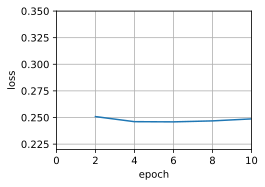

In [14]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)
gd_res = train_sgd(1, 1500, 10)


当批量⼤⼩为1时，优化使⽤的是随机梯度下降。为了简化实现，我们选择了很⼩的学习率。在随机梯度下
降的实验中，每当⼀个样本被处理，模型参数都会更新。在这个例⼦中，这相当于每个迭代轮数有1500次更
新。可以看到，⽬标函数值的下降在1个迭代轮数后就变得较为平缓。尽管两个例⼦在⼀个迭代轮数内都处理
了1500个样本，但实验中随机梯度下降的⼀个迭代轮数耗时更多。这是因为随机梯度下降更频繁地更新了参
数，⽽且⼀次处理单个观测值效率较低。

loss: 0.242, 0.000 sec/epoch


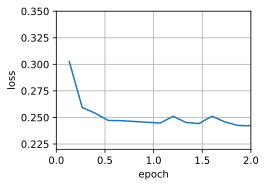

In [15]:
sgd_res = train_sgd(0.005, 1)


最后，当批量⼤⼩等于100时，我们使⽤⼩批量随机梯度下降进⾏优化。每个迭代轮数所需的时间⽐随机梯度
下降和批量梯度下降所需的时间短。


loss: 0.244, 0.001 sec/epoch


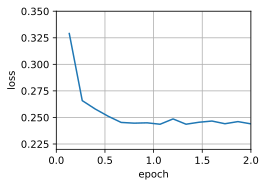

In [16]:
mini1_res = train_sgd(.4, 100)


将批量⼤⼩减少到10，每个迭代轮数的时间都会增加，因为每批⼯作负载的执⾏效率变得更低。


loss: 0.244, 0.000 sec/epoch


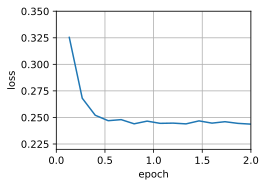

In [18]:
mini2_res = train_sgd(.05, 10)


现在我们可以⽐较前四个实验的时间与损失。可以看出，尽管在处理的样本数⽅⾯，随机梯度下降的收敛速
度快于梯度下降，但与梯度下降相⽐，它需要更多的时间来达到同样的损失，因为逐个样本来计算梯度并不
那么有效。⼩批量随机梯度下降能够平衡收敛速度和计算效率。⼤⼩为10的⼩批量⽐随机梯度下降更有效；
⼤⼩为100的⼩批量在运⾏时间上甚⾄优于梯度下降。

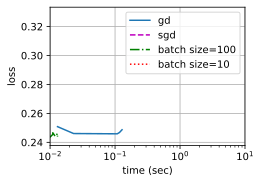

In [21]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')


### 简洁实现
下⾯⽤深度学习框架⾃带算法实现⼀个通⽤的训练函数，我们将在本章中其它⼩节使⽤它。


In [22]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    
    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss计算平⽅误差时不带系数1/2
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

使⽤这个训练函数，复现之前的实验。

loss: 0.244, 0.007 sec/epoch


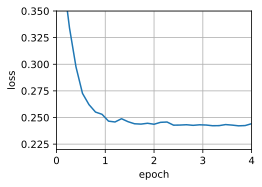

In [23]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

### 小结
* 由于减少了深度学习框架的额外开销，使⽤更好的内存定位以及CPU和GPU上的缓存，向量化使代码更加⾼效。
* 随机梯度下降的“统计效率”与⼤批量⼀次处理数据的“计算效率”之间存在权衡。⼩批量随机梯度下降提供了两全其美的答案：计算和统计效率。
* 在⼩批量随机梯度下降中，我们处理通过训练数据的随机排列获得的批量数据（即每个观测值只处理⼀次，但按随机顺序）。
* 在训练期间降低学习率有助于训练。
* ⼀般来说，⼩批量随机梯度下降⽐随机梯度下降和梯度下降的速度快，收敛⻛险较⼩。


